In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob

from clim_utils import daily_climo_subx

In [2]:
base_path='/glade/scratch/kpegion/ESPWG/data/'

In [3]:
def preproc(ds):
    

    if (len(ds['time'])<34):
              
        ds['lat']=(np.arange(-90,91))
        
        tmpdata=np.zeros((34,len(ds['lat']),len(ds['lon'])))
        tmpdata[:,:,:]=np.nan
        ds_tmp=xr.DataArray(tmpdata,
                            coords={'time': np.arange(0,34).astype('float64'), 
                                    'lat':ds['lat'].astype('float32'),
                                    'lon': ds['lon'].astype('float32')},
                            dims=['time', 'lat','lon'])        
        ds=ds_tmp.to_dataset(name='tas_2m')
        
    else:                          
        ds=ds.isel(time=slice(0,34))
    
    return ds

### Get Weekly FCST Anomalies for CESM hindcasts

In [4]:
# File Path information
#model='70Lwaccm6'
#path='/glade/p/nsc/ncgd0042/ssfcst/'+model+'70Lwaccm6'/p1/'
#dstr='00z_d01_d45'

model='CESM1_30LCAM5'
path='/glade/scratch/jrichter/CPC_DATA/'+model
dstr='00z_d01_d45'

# Variable to be processed
varname='tas_2m'
#varname='pr'

# Years to be gotton
sdate='19990106' # This was set by hand as the first init date for the first year
edate='20151231'
yrs_list=np.arange(1999,2016)

# Initialization months
mnums=['01','02','12']
mstrs=['jan','feb','dec']

# Ensemble members
enss=['00','01','02','03','04'] 

In [5]:
# Create empty list to append data for each ensemble member
fcst_ds_ens=[]

# Loop over ensembles
for iens in enss:

    # Create empty list to append data for each month
    fcst_ds_months=[]
    
    # Get list of files and read in data for each month for this ensemble member
    for mnum,mstr in zip(mnums,mstrs):
        
        # Get all the filenames for this month for all years
        fnames = [f'{path}/{varname}/{year}/{mnum}/{varname}_{model}_*{mstr}{year}_{dstr}_m{iens}.nc' for year in yrs_list]       
        print(fnames)
        
        # Create list of all filenames for this ensemble member, month, and all years
        files1=[]
        for files in fnames:
            f2=glob.glob(files)
            for f in f2:
                files1.append(f)
       
        # Read in data concatentating over the init dimension
        fcst_ds_tmp=xr.open_mfdataset(files1,parallel=True,combine='nested',
                                      decode_times=False,concat_dim='init')

        # Create dates for the init dimension and assign them
        init_dates_all=pd.date_range(start=sdate,end=edate,freq='7D')
        djf_dates=init_dates_all[(init_dates_all.month==int(mnum))]
        fcst_ds_tmp['init']=djf_dates

        # Append the latest month to the list
        fcst_ds_months.append(fcst_ds_tmp)
        
    
    # Combine the months into the init dimension
    fcst_ds_months = xr.combine_nested(fcst_ds_months, concat_dim=['init'])
    
    # Append this ensenble member
    fcst_ds_ens.append(fcst_ds_months)
    
    
fcst_ds_ens   

['/glade/scratch/jrichter/CPC_DATA/CESM1_30LCAM5/tas_2m/1999/01/tas_2m_CESM1_30LCAM5_*jan1999_00z_d01_d45_m00.nc', '/glade/scratch/jrichter/CPC_DATA/CESM1_30LCAM5/tas_2m/2000/01/tas_2m_CESM1_30LCAM5_*jan2000_00z_d01_d45_m00.nc', '/glade/scratch/jrichter/CPC_DATA/CESM1_30LCAM5/tas_2m/2001/01/tas_2m_CESM1_30LCAM5_*jan2001_00z_d01_d45_m00.nc', '/glade/scratch/jrichter/CPC_DATA/CESM1_30LCAM5/tas_2m/2002/01/tas_2m_CESM1_30LCAM5_*jan2002_00z_d01_d45_m00.nc', '/glade/scratch/jrichter/CPC_DATA/CESM1_30LCAM5/tas_2m/2003/01/tas_2m_CESM1_30LCAM5_*jan2003_00z_d01_d45_m00.nc', '/glade/scratch/jrichter/CPC_DATA/CESM1_30LCAM5/tas_2m/2004/01/tas_2m_CESM1_30LCAM5_*jan2004_00z_d01_d45_m00.nc', '/glade/scratch/jrichter/CPC_DATA/CESM1_30LCAM5/tas_2m/2005/01/tas_2m_CESM1_30LCAM5_*jan2005_00z_d01_d45_m00.nc', '/glade/scratch/jrichter/CPC_DATA/CESM1_30LCAM5/tas_2m/2006/01/tas_2m_CESM1_30LCAM5_*jan2006_00z_d01_d45_m00.nc', '/glade/scratch/jrichter/CPC_DATA/CESM1_30LCAM5/tas_2m/2007/01/tas_2m_CESM1_30LCAM5_*ja

[<xarray.Dataset>
 Dimensions:  (LAT: 181, LON: 360, TIME: 45, init: 220)
 Coordinates:
   * LAT      (LAT) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
   * LON      (LON) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
   * TIME     (TIME) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 40.5 41.5 42.5 43.5 44.5
   * init     (init) datetime64[ns] 1999-01-06 1999-01-13 ... 2015-12-30
 Data variables:
     TAS      (init, TIME, LAT, LON) float32 dask.array<chunksize=(1, 45, 181, 360), meta=np.ndarray>
 Attributes:
     institution_id:  NCAR and NOAA/ESRL/PSD
     institution:     National Center for Atmospheric Research and NOAA Earth ...
     experiment_id:   Wed Nov 29 13:27:44 MST 2017
     model_id:        CESM1_30LCAM5
     frequency:       daily
     project_id:      SUBx project
     experiment:      1999-01-27 IC Sub-seasonal Forecast
     modeling_realm:  atmos
     realization:     000
     contact:         Jadwiga (Yaga) Richter (jrichter@ucar.edu), Judith

In [6]:
# Combine data over ensemble dimension
fcst_ds_ens = xr.combine_nested(fcst_ds_ens, concat_dim=['ens'])
fcst_ds_ens['ens']=np.arange(0,len(enss))

fcst_ds_ens

,Array,Chunk
Bytes,12.90 GB,11.73 MB
Shape,"(5, 220, 45, 181, 360)","(1, 1, 45, 181, 360)"
Count,7700 Tasks,1100 Chunks
Type,float32,numpy.ndarray


In [7]:
fcst_ds=fcst_ds_ens.mean(dim='ens')
del fcst_ds_ens

In [8]:
# Determine leads and set them as integers 
nt=fcst_ds['TIME'].size
leads=np.arange(0,nt)
fcst_ds=fcst_ds.rename({'TIME':'lead','LAT':'lat','LON':'lon','TAS':varname})
fcst_ds['lead']=leads

In [9]:
# Read Climo
climo_path=base_path+model+'/hcst/climo/'
climo_fcst_fname=climo_path+'climo_'+varname+'.nc'
climo_fcst=xr.open_dataset(climo_fcst_fname,decode_times=True)

climo_fcst

<xarray.Dataset>
Dimensions:    (dayofyear: 92, lat: 181, lead: 45, lon: 360)
Coordinates:
  * lat        (lat) float32 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lon        (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lead       (lead) int64 0 1 2 3 4 5 6 7 8 9 ... 36 37 38 39 40 41 42 43 44
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Data variables:
    tas_2m     (dayofyear, lead, lat, lon) float64 ...

In [10]:
# Calc Anoms
anoms_fcst=fcst_ds.groupby('init.dayofyear')-climo_fcst
anoms_fcst

,Array,Chunk
Bytes,5.16 GB,23.46 MB
Shape,"(220, 45, 181, 360)","(1, 45, 181, 360)"
Count,10432 Tasks,220 Chunks
Type,float64,numpy.ndarray


### Get the verification anomalies for Week 1 forecasts from the fcst init dates

In [11]:
varname2='tas2m'
verif_path=base_path+'verif/'
verif_dataset='CPC-TEMP'

In [12]:
# Read in verif data for 1999-2015 and calculate climo
verif_files_tmax = [f'{verif_path}{varname2}/daily/{verif_dataset}/orig/tmax.{year}.nc' for year in range(1999, 2016)]
verif_files_tmin = [f'{verif_path}{varname2}/daily/{verif_dataset}/orig/tmin.{year}.nc' for year in range(1999, 2016)]
verif_files_tmax

['/glade/scratch/kpegion/ESPWG/data/verif/tas2m/daily/CPC-TEMP/orig/tmax.1999.nc',
 '/glade/scratch/kpegion/ESPWG/data/verif/tas2m/daily/CPC-TEMP/orig/tmax.2000.nc',
 '/glade/scratch/kpegion/ESPWG/data/verif/tas2m/daily/CPC-TEMP/orig/tmax.2001.nc',
 '/glade/scratch/kpegion/ESPWG/data/verif/tas2m/daily/CPC-TEMP/orig/tmax.2002.nc',
 '/glade/scratch/kpegion/ESPWG/data/verif/tas2m/daily/CPC-TEMP/orig/tmax.2003.nc',
 '/glade/scratch/kpegion/ESPWG/data/verif/tas2m/daily/CPC-TEMP/orig/tmax.2004.nc',
 '/glade/scratch/kpegion/ESPWG/data/verif/tas2m/daily/CPC-TEMP/orig/tmax.2005.nc',
 '/glade/scratch/kpegion/ESPWG/data/verif/tas2m/daily/CPC-TEMP/orig/tmax.2006.nc',
 '/glade/scratch/kpegion/ESPWG/data/verif/tas2m/daily/CPC-TEMP/orig/tmax.2007.nc',
 '/glade/scratch/kpegion/ESPWG/data/verif/tas2m/daily/CPC-TEMP/orig/tmax.2008.nc',
 '/glade/scratch/kpegion/ESPWG/data/verif/tas2m/daily/CPC-TEMP/orig/tmax.2009.nc',
 '/glade/scratch/kpegion/ESPWG/data/verif/tas2m/daily/CPC-TEMP/orig/tmax.2010.nc',
 '/g

In [13]:
verif_ds_tmax=xr.open_mfdataset(verif_files_tmax,decode_times=True,combine='by_coords',
                                parallel=True)  
verif_ds_tmin=xr.open_mfdataset(verif_files_tmin,decode_times=True,combine='by_coords',
                                parallel=True) 

In [14]:
verif_ds_tmax=verif_ds_tmax.rename({'tmax':varname2})
verif_ds_tmin=verif_ds_tmin.rename({'tmin':varname2})
verif_ds=(verif_ds_tmax+verif_ds_tmin)*0.5
verif_ds

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 6209)
Coordinates:
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 0.25 0.75 1.25 1.75 ... 358.25 358.75 359.25 359.75
  * time     (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2015-12-31
Data variables:
    tas2m    (time, lat, lon) float32 dask.array<chunksize=(365, 360, 720), meta=np.ndarray>

In [15]:
# Read Climo
verif_climo_path=verif_path+varname2+'/daily/'+verif_dataset+'/climo/'
climo_verif_fname=verif_climo_path+'climo_'+verif_dataset+'_'+varname2+'.nc'
climo_verif=xr.open_dataset(climo_verif_fname,decode_times=True)

In [16]:
# Calc Anoms
anoms_verif=verif_ds.groupby('time.dayofyear')-climo_verif

In [17]:
# Rename the variable in fcst to match verif for interpolation to work
anoms_fcst=anoms_fcst.rename({varname:varname2})

In [18]:
# Interpolate verif to fcst 1x1 grid
verif1x1=anoms_verif.interp_like(anoms_fcst)
verif1x1=verif1x1.chunk({'time':-1})
verif1x1

<xarray.Dataset>
Dimensions:    (lat: 181, lon: 360, time: 6209)
Coordinates:
  * time       (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2015-12-31
    dayofyear  (time) int64 dask.array<chunksize=(6209,), meta=np.ndarray>
  * lat        (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lon        (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
Data variables:
    tas2m      (time, lat, lon) float64 dask.array<chunksize=(6209, 181, 360), meta=np.ndarray>

In [19]:
fcstweekly=anoms_fcst.rolling(lead=7,center=False).mean().dropna(dim='lead')

In [20]:
verifweekly=verif1x1.rolling(time=7,center=False).mean()

In [21]:
fcstweekly

,Array,Chunk
Bytes,4.47 GB,20.33 MB
Shape,"(220, 39, 181, 360)","(1, 39, 181, 360)"
Count,26052 Tasks,220 Chunks
Type,float64,numpy.ndarray


In [22]:
verifweekly

<xarray.Dataset>
Dimensions:    (lat: 181, lon: 360, time: 6209)
Coordinates:
  * time       (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2015-12-31
    dayofyear  (time) int64 dask.array<chunksize=(6209,), meta=np.ndarray>
  * lat        (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lon        (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
Data variables:
    tas2m      (time, lat, lon) float64 dask.array<chunksize=(3, 181, 360), meta=np.ndarray>

In [23]:
nleads=fcstweekly['lead'][::7].size
fcstweeklyda=xr.DataArray(fcstweekly[varname2][:,::7,:,:],
                           coords={'init' : fcstweekly['init'],
                                   'lead': np.arange(1,nleads+1),
                                   'lat' : fcstweekly['lat'],
                                   'lon' : fcstweekly['lon']
                                   },
                           dims=['init', 'lead','lat','lon'])
fcstweeklyda.name = varname2
fcstweeklyda['lead'].attrs={'units': 'weeks'}
del fcstweekly

In [24]:
fcstweeklyda

<xarray.DataArray 'tas2m' (init: 220, lead: 6, lat: 181, lon: 360)>
array([[[[ 1.33513717,  1.33513717,  1.33513717, ...,  1.33513717,
           1.33513717,  1.33513717],
         [ 1.49686432,  1.5004196 ,  1.50398383, ...,  1.48494105,
           1.48891433,  1.49288351],
         [ 1.4752626 ,  1.48054858,  1.4858366 , ...,  1.46984601,
           1.4716582 ,  1.47346359],
         ...,
         [-3.41843182, -3.42397053, -3.42950757, ..., -3.39479635,
          -3.40266194, -3.41054228],
         [-3.40961646, -3.41180811, -3.41397279, ..., -3.40133969,
          -3.40410692, -3.40686776],
         [-3.48203055, -3.48203055, -3.48203055, ..., -3.48203055,
          -3.48203055, -3.48203055]],

        [[-0.9663796 , -0.9663796 , -0.9663796 , ..., -0.9663796 ,
          -0.9663796 , -0.9663796 ],
         [-1.03654149, -1.03318247, -1.02979732, ..., -1.04065895,
          -1.03930579, -1.03793817],
         [-1.12129942, -1.11375456, -1.10615733, ..., -1.11425929,
          -1.11663205, -1.11899098],
         ...,
         [-2.95368565, -2.9746335 , -2.99552261, ..., -2.86499509,
          -2.8945955 , -2.92415808],
         [-2.837772  , -2.84822655, -2.85865109, ..., -2.7977341 ,
          -2.81110878, -2.82445182],
         [-2.88987944, -2.88987944, -2.88987944, ..., -2.88987944,
          -2.88987944, -2.88987944]],

        [[-3.12095081, -3.12095081, -3.12095081, ..., -3.12095081,
          -3.12095081, -3.12095081],
         [-3.69020841, -3.6905515 , -3.690725  , ..., -3.6869062 ,
          -3.68817322, -3.68928113],
         [-4.27010312, -4.26496785, -4.25952528, ..., -4.25385037,
          -4.25958078, -4.2650025 ],
         ...,
         [-1.78425592, -1.79608091, -1.80778768, ..., -1.71784556,
          -1.74006012, -1.76221015],
         [-1.57541878, -1.58029794, -1.58510371, ..., -1.54911444,
          -1.55793986, -1.56670718],
         [-1.39779912, -1.39779912, -1.39779912, ..., -1.39779912,
          -1.39779912, -1.39779912]],

        [[-5.17463357, -5.17463357, -5.17463357, ..., -5.17463357,
          -5.17463357, -5.17463357],
         [-5.58995615, -5.58784049, -5.58561768, ..., -5.58822018,
          -5.58890015, -5.58948038],
         [-5.9115582 , -5.90630889, -5.90090305, ..., -5.89868307,
          -5.90312131, -5.90741889],
         ...,
         [-1.20392656, -1.21286712, -1.22218875, ..., -1.18274373,
          -1.18938683, -1.19645019],
         [-1.92863034, -1.93025346, -1.93209763, ..., -1.92160755,
          -1.92373906, -1.92607985],
         [-2.71081123, -2.71081123, -2.71081123, ..., -2.71081123,
          -2.71081123, -2.71081123]],

        [[-5.0374378 , -5.0374378 , -5.0374378 , ..., -5.0374378 ,
          -5.0374378 , -5.0374378 ],
         [-5.58874548, -5.5911508 , -5.59342502, ..., -5.56462226,
          -5.57277418, -5.58081784],
         [-6.02386668, -6.02981626, -6.03552276, ..., -5.96444493,
          -5.98446369, -6.0042784 ],
         ...,
         [ 1.70331485,  1.70326937,  1.7028975 , ...,  1.67837783,
           1.68697932,  1.69530544],
         [ 1.14199429,  1.14052352,  1.13890886, ...,  1.14060043,
           1.14121468,  1.14168688],
         [ 0.48372079,  0.48372079,  0.48372079, ...,  0.48372079,
           0.48372079,  0.48372079]],

        [[-5.24552315, -5.24552315, -5.24552315, ..., -5.24552315,
          -5.24552315, -5.24552315],
         [-5.9928287 , -5.99214379, -5.99134731, ..., -5.98580886,
          -5.98827614, -5.99060334],
         [-6.38085555, -6.37425287, -6.36745344, ..., -6.37386514,
          -6.37639938, -6.37874893],
         ...,
         [ 3.18758249,  3.18127469,  3.17478998, ...,  3.19684592,
           3.19394879,  3.19085742],
         [ 2.84844874,  2.84650242,  2.84447521, ...,  2.85549229,
           2.8532426 ,  2.85089313],
         [ 2.36567537,  2.36567537,  2.36567537, ...,  2.36567537,
           2.36567537,  2.36567537]]],


       [[[ 2.37632267,  2.37632267,  2.37632267, ...,  2.37632267,
           2.37632267, 

### Now calculate skill

In [25]:
from climpred import HindcastEnsemble
import climpred

In [26]:
hindcast = HindcastEnsemble(fcstweeklyda)
hindcast = hindcast.add_observations(verifweekly, 'obs')

In [27]:
skill = hindcast.verify(metric='acc')
skill

<xarray.Dataset>
Dimensions:  (lat: 181, lead: 6, lon: 360)
Coordinates:
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lead     (lead) int64 1 2 3 4 5 6
Data variables:
    tas2m    (lead, lat, lon) float64 dask.array<chunksize=(1, 181, 360), meta=np.ndarray>
Attributes:
    prediction_skill:              calculated by climpred https://climpred.re...
    skill_calculated_by_function:  compute_hindcast
    number_of_initializations:     220
    metric:                        pearson_r
    comparison:                    e2o
    dim:                           time
    units:                         None
    created:                       2020-04-24 17:01:16

In [28]:
skill['tas2m'][0,:,:]

<xarray.DataArray 'tas2m' (lat: 181, lon: 360)>
dask.array<getitem, shape=(181, 360), dtype=float64, chunksize=(181, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
    lead     int64 1

/glade/u/home/kpegion/miniconda3/envs/myenv/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/kpegion/miniconda3/envs/myenv/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/kpegion/miniconda3/envs/myenv/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/kpegion/miniconda3/envs/myenv/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


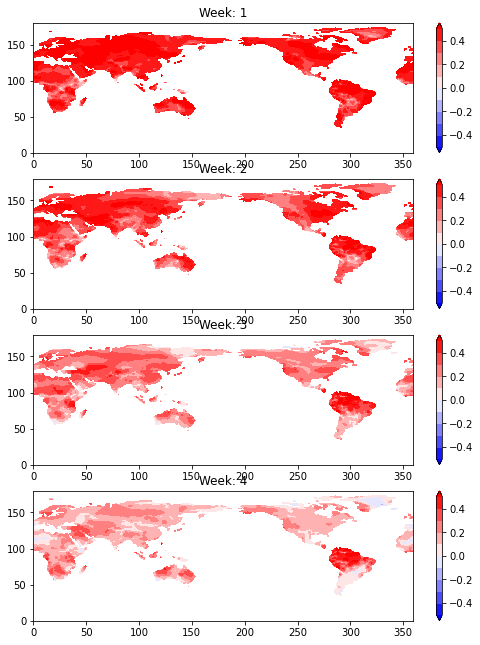

In [29]:
plt.figure(figsize=(8.5,11))
levs=np.arange(-0.5,0.6,0.1)
for iweek in np.arange(4):
    plt.subplot(4,1,iweek+1)
    plt.contourf(skill['tas2m'][iweek,:,:],levs,cmap='bwr',extend='both')
    plt.title('Week: '+(iweek+1).astype(str))
    plt.colorbar()

In [31]:
outfile=base_path+model+'/hcst/skill/'+model+'.'+varname+'.acc.emean.DJF.1999-2015.nc'
skill.to_netcdf(outfile)

/glade/u/home/kpegion/miniconda3/envs/myenv/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
